In [24]:
import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from libpysal.graph import read_parquet
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler

regions_datadir = "/data/uscuni-ulce/"
data_dir = "/data/uscuni-ulce/processed_data/"
eubucco_files = glob.glob(regions_datadir + "eubucco_raw/*")
graph_dir = data_dir + "neigh_graphs/"
chars_dir = "/data/uscuni-ulce/processed_data/chars/"

In [25]:
from core.cluster_validation import generate_enc_groups
from core.utils import used_keys

In [26]:
import umap
import umap.plot
from palettable.colorbrewer.qualitative import Set3_12
from sklearn.metrics import davies_bouldin_score

### Merge data

In [27]:
region_id = 69300

In [28]:
tessellation = gpd.read_parquet(chars_dir + f"tessellations/chars_{region_id}.parquet")
buildings = gpd.read_parquet(chars_dir + f"buildings/chars_{region_id}.parquet")
enclosures = gpd.read_parquet(chars_dir + f"enclosures/chars_{region_id}.parquet")
streets = gpd.read_parquet(chars_dir + f"streets/chars_{region_id}.parquet")
nodes = gpd.read_parquet(chars_dir + f"nodes/chars_{region_id}.parquet")


merged = pd.merge(
    tessellation.drop(columns=["geometry"]),
    buildings.drop(columns=["nodeID", "geometry", 'nID']),
    right_index=True,
    left_index=True,
    how="left",
)

merged = merged.merge(
    enclosures.drop(columns="geometry"),
    right_on="eID",
    left_on="enclosure_index",
    how="left",
)

merged = merged.merge(streets.drop(columns="geometry"), on="nID", how="left")
merged = merged.merge(nodes.drop(columns="geometry"), on="nodeID", how="left")

merged = merged.drop(
    columns=[
        "nID",
        "eID",
        "nodeID",
        "mm_len",
        "cdsbool",
        "node_start",
        "node_end",
        "x",
        "y",
        "enclosure_index",
        # "id",
        # "osm_id",
        "index",  ## maybe keep
    ]
)
merged = merged.set_index(tessellation.index)

In [29]:
primary = merged[list(used_keys.keys())]

### Generate context

In [30]:
@numba.njit(parallel=True)
def numba_limit_range(rows, cols, partial_vals, output_vals):
    # print(partial_vals)
    ngroups = int(rows[-1]) + 1
    nrows = rows.shape[0]
    result = np.empty((ngroups, partial_vals.shape[1] * output_vals))

    istart = 0
    for g in range(ngroups):
        # # find focal start
        # istart = 0
        # while istart < nrows and rows[istart] != g:
        #     istart += 1

        # find neighbors
        iend = istart + 1
        while iend < nrows and rows[iend - 1] == rows[iend]:
            iend += 1

        ## for every column apply iqr and percentiles
        for c in numba.prange(partial_vals.shape[1]):
            col_vals = partial_vals[cols[istart:iend], c]
            res_index = output_vals * c

            if np.isnan(col_vals).all():
                result[g, res_index] = np.nan
                result[g, res_index + 1] = np.nan
                result[g, res_index + 2] = np.nan
                continue

            lower, med, higher = np.nanpercentile(col_vals, (15, 50, 85))
            result[g, res_index] = lower
            result[g, res_index + 1] = med
            result[g, res_index + 2] = higher

        # # go to next group
        istart = iend
    return result

In [31]:
def parallel_higher_order_context(df, graph, k, n_splits, output_vals):
    A = graph.transform("B").sparse
    ids = graph.unique_ids.values
    rows = np.arange(A.shape[0])
    values = df.values

    final_result = pd.DataFrame(
        np.empty((values.shape[0], values.shape[1] * output_vals)), index=ids
    )

    for source in np.array_split(rows, n_splits):
        Q = A[source, :].copy()
        for _ in range(1, k):
            next_step = Q @ A
            Q += next_step

        sparray = Q.tocoo(copy=False)
        sorter = sparray.row.argsort()
        unique_tail = np.unique(sparray.col)
        partial_vals = values[unique_tail, :]

        cols_dict = pd.Series(np.arange(len(unique_tail)), index=unique_tail)
        columns_to_pass = cols_dict.loc[sparray.col].values
        rows_to_pass = sparray.row[sorter]

        partial_res = numba_limit_range(
            rows_to_pass, columns_to_pass, partial_vals, output_vals
        )

        final_result.iloc[source, :] = partial_res

    return final_result

In [32]:
graph = read_parquet(graph_dir + f"tessellation_graph_{region_id}_knn1.parquet")

In [33]:
## Discard disconnected components and focus on a single component only.
## doesnt make a big difference.

In [34]:
graph.component_labels.value_counts()

component labels
0      329707
1         381
34        285
27        174
12        138
        ...  
101         1
103         1
106         1
111         1
113         1
Name: count, Length: 114, dtype: int64

In [35]:
component_labels = graph.component_labels.copy()
component_labels = component_labels[component_labels == 0].index.values

In [36]:
# data = primary.loc[primary.index >= 0]
# data_graph = graph.subgraph(graph.unique_ids[graph.unique_ids >= 0])

In [37]:
data = primary.loc[component_labels]
data_graph = graph.subgraph(component_labels)

In [38]:
# ## no spatial lag
# data = PowerTransformer().fit_transform(data)
# data = pd.DataFrame(data, columns=primary.columns, index=primary.loc[component_labels].index)

In [39]:
# data['sdbAre'].hist()

In [40]:
# primary['sdbAre'].hist()

In [41]:
%%time
context = parallel_higher_order_context(
    data, data_graph, k=5, n_splits=10, output_vals=3
)

CPU times: user 8min 16s, sys: 17.2 s, total: 8min 33s
Wall time: 48.7 s


In [42]:
context.columns = np.concatenate(
    [(c + "_lower", c + "_median", c + "_higher") for c in primary.columns]
)

In [43]:
# X = context

In [44]:
# higher = graph.higher_order(k=3, lower_order=True, diagonal=True)
# r = higher.describe(primary['sdbAre'], statistics=['median'])['median']
# from pandas.testing import assert_series_equal
# assert_series_equal(context['sdbAre_median'], r, check_names=False)

# r.duplicated().sum()

### Data preprocessing

In [45]:
tess_groups = generate_enc_groups(tessellation, enclosures, include_random_sample=True)


def check_score(data, example_clusters):
    groups = example_clusters[example_clusters.index.isin(data.index)]
    groups_ilocs = (
        pd.Series(np.arange(len(data)), index=data.index).loc[groups.index].values
    )
    return davies_bouldin_score(data.iloc[groups_ilocs], groups.values)

In [46]:
## no spatial lag
X = np.nan_to_num(StandardScaler().fit_transform(data))
X = pd.DataFrame(X, columns=data.columns, index=data.index)
check_score(X, tess_groups)

np.float64(4.474370711808999)

In [47]:
## no spatial lag
X = np.nan_to_num(RobustScaler().fit_transform(data))
X = pd.DataFrame(X, columns=data.columns, index=data.index)
check_score(X, tess_groups)

np.float64(6.598450725764589)

In [48]:
## no spatial lag
X = np.nan_to_num(PowerTransformer().fit_transform(data))
X = pd.DataFrame(X, columns=data.columns, index=data.index)
check_score(X, tess_groups)

np.float64(4.603055410245461)

In [49]:
### only medians

In [50]:
X = np.nan_to_num(
    StandardScaler().fit_transform(
        context.loc[:, context.columns.str.endswith("_median")]
    )
)
X = pd.DataFrame(
    X,
    columns=context.loc[:, context.columns.str.endswith("_median")].columns,
    index=context.loc[:, context.columns.str.endswith("_median")].index,
)
check_score(X, tess_groups)

np.float64(2.781877411166254)

In [51]:
X = np.nan_to_num(
    RobustScaler().fit_transform(
        context.loc[:, context.columns.str.endswith("_median")]
    )
)
X = pd.DataFrame(
    X,
    columns=context.loc[:, context.columns.str.endswith("_median")].columns,
    index=context.loc[:, context.columns.str.endswith("_median")].index,
)
check_score(X, tess_groups)

np.float64(4.731190840421226)

In [52]:
X = np.nan_to_num(
    PowerTransformer().fit_transform(
        context.loc[:, context.columns.str.endswith("_median")] + 1
    )
)
X = pd.DataFrame(
    X,
    columns=context.loc[:, context.columns.str.endswith("_median")].columns,
    index=context.loc[:, context.columns.str.endswith("_median")].index,
)
check_score(X, tess_groups)

np.float64(2.6978259145122263)

In [53]:
## clip to -10, 10 standard deviations
X = np.nan_to_num(
    StandardScaler().fit_transform(
        context.loc[:, context.columns.str.endswith("_median")]
    )
)
X = pd.DataFrame(
    X,
    columns=context.loc[:, context.columns.str.endswith("_median")].columns,
    index=context.loc[:, context.columns.str.endswith("_median")].index,
)
X = X.clip(-10, 10)
check_score(X, tess_groups)

np.float64(2.7722681439823393)

In [54]:
# all features with lag

In [55]:
# no standardisation
X = np.nan_to_num(context)
X = pd.DataFrame(X, columns=context.columns, index=context.index)
check_score(X, tess_groups)

np.float64(2.8280316397084184)

In [56]:
X = np.nan_to_num(StandardScaler().fit_transform(context))
X = pd.DataFrame(X, columns=context.columns, index=context.index)
check_score(X, tess_groups)

np.float64(2.898826549656451)

In [57]:
X = np.nan_to_num(RobustScaler().fit_transform(context))
X = pd.DataFrame(X, columns=context.columns, index=context.index)
check_score(X, tess_groups)

np.float64(3.746690148593416)

In [58]:
X = np.nan_to_num(PowerTransformer().fit_transform(context + 1))
X = pd.DataFrame(X, columns=context.columns, index=context.index)
check_score(X, tess_groups)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numpy/_core/_methods.py:188: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numpy/_core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


np.float64(2.7788287443361694)

In [59]:
## clip to -10, 10 standard deviations
X = np.nan_to_num(StandardScaler().fit_transform(context))
X = pd.DataFrame(X, columns=context.columns, index=context.index)
X = X.clip(-10, 10)
check_score(X, tess_groups)

np.float64(2.8785430783748653)

In [60]:
context["sdbAre_lower"].describe()

count    328982.000000
mean         36.832808
std          26.654504
min           9.614216
25%          22.331379
50%          27.952382
75%          40.075619
max         312.522809
Name: sdbAre_lower, dtype: float64

In [61]:
desc = X.describe()

In [62]:
desc.loc[["25%", "50%", "75%", "max"]]

sdbAre_lower  sdbAre_median  sdbAre_higher  sdbPer_lower  sdbPer_median  \
25%     -0.543583      -0.535282      -0.501158     -0.636402      -0.511880   
50%     -0.331928      -0.212337      -0.300928     -0.324235      -0.140712   
75%      0.119925       0.141367       0.112357      0.278680       0.285048   
max     10.000000      10.000000      10.000000      7.114962       8.535010   

     sdbPer_higher  sdbCoA_lower  sdbCoA_median  sdbCoA_higher  ssbCCo_lower  \
25%      -0.542801           0.0            0.0      -0.033086     -0.628885   
50%      -0.267458           0.0            0.0      -0.033086      0.055706   
75%       0.215479           0.0            0.0      -0.033086      0.654691   
max      10.000000           0.0            0.0      10.000000      4.230432   

     ...  lskCWA_higher  ltkOri_lower  ltkOri_median  ltkOri_higher  \
25%  ...      -0.815940     -0.700723      -0.704337      -0.668079   
50%  ...      -0.123187     -0.326580      -0.060542       0.268689   
75%  ...       0.632137      0.463623       0.685877       0.755176   
max  ...       3.604022      4.194301       2.599209       1.440044   

     ltkWNB_lower  ltkWNB_median  ltkWNB_higher  likWBB_lower  likWBB_median  \
25%     -0.713018      -0.772949      -0.661050     -0.726002      -0.733160   
50%     -0.290397      -0.327188      -0.170538     -0.267722      -0.234092   
75%      0.414617       0.562307       0.487543      0.472000       0.459465   
max      7.091311       5.880513      10.000000      6.589470       5.069518   

     likWBB_higher  
25%      -0.696059  
50%      -0.160470  
75%       0.360203  
max       4.358023  

[4 rows x 183 columns]

In [63]:
corrs = context.corr().abs()
upper = corrs.where(np.triu(np.ones(corrs.shape), k=1).astype(bool))

In [64]:
corrs_to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
corrs_to_drop

['sdbPer_lower',
 'sdbPer_median',
 'ssbSqu_lower',
 'ssbSqu_median',
 'ssbCCM_lower',
 'ssbCCM_median',
 'ssbCCM_higher',
 'ldkPer_lower',
 'lskCWA_lower',
 'lskCWA_median',
 'lskCWA_higher']

In [65]:
X_no_corr = X.drop(columns=corrs_to_drop)
X_no_corr.shape, check_score(X_no_corr, tess_groups)

((329707, 172), np.float64(2.923918308457853))

In [66]:
# corrs_to_drop = []
# X_no_corr = X.drop(columns=corrs_to_drop)
# X_no_corr.shape, check_score(X_no_corr, tess_groups)

In [67]:
# X.describe()

In [68]:
desc = X_no_corr.describe()
to_drop = desc.columns[(desc.loc["max"] - desc.loc["min"]) < 0.5].values
to_drop

array(['sdbCoA_lower', 'sdbCoA_median'], dtype=object)

In [69]:
X_different = X_no_corr.drop(columns=to_drop)
X_different.shape, check_score(X_different, tess_groups)

((329707, 170), np.float64(2.9239183084578535))

In [70]:
X_no_duplicates = X_different[~X_different.duplicated()]
X_no_duplicates.shape, check_score(X_no_duplicates, tess_groups)

((284636, 170), np.float64(2.8953232279711454))

In [71]:
# tessellation[X_different.duplicated(keep=False)].explore()

In [72]:
# plotting = tessellation.loc[X_different[X_different.duplicated(keep=False)].index.values]
# plotting['sdbAre_lower'] = X_different[X_different.duplicated(keep=False)]['sdbAre_lower']
# plotting = plotting.sort_values('sdbAre_lower')
# plotting['sdbAre_lower']

In [73]:
# layer = PolygonLayer.from_geopandas(
#     gdf=plotting[['geometry', 'sdbAre_lower']],
#     opacity=.15
# )
# m = Map(layer, basemap_style=CartoBasemap.Positron)
# m

In [74]:
# tessellation.loc[higher[21149].index.values, ].explore()

In [75]:
# tessellation.loc[higher[271717].index.values, ].explore()

In [76]:
# higher = graph.higher_order(k=3, lower_order=True, diagonal=True)

In [77]:
# primary.loc[higher[271717].index.values, 'sdbAre'].median(), primary.loc[higher[271714].index.values, 'sdbAre'].median()

In [78]:
# primary.loc[higher[271717].index.values, 'sdbAre'].describe()

In [79]:
# primary.loc[higher[271714].index.values, 'sdbAre'].describe()

In [80]:
# r = dict([])
# for idx in higher[271717].index.values:
#     r[idx] = (primary.loc[higher[idx].index.values, 'sdbAre'].median())

In [81]:
# dict(sorted(r.items(), key=lambda item: item[1]))

In [82]:
# remove singletons

In [83]:
singletons = graph.unique_ids[graph.cardinalities == 1]

In [84]:
# tessellation.loc[singletons].explore()

In [85]:
X_no_singletons = X_no_duplicates[~X_no_duplicates.index.isin(singletons)]
X_no_singletons.shape, check_score(X_no_singletons, tess_groups)

((284636, 170), np.float64(2.8953232279711454))

In [86]:
# remove empty space

In [87]:
X_buildings = X_no_singletons[X_no_singletons.index >= 0]
X_buildings.shape, check_score(X_buildings, tess_groups)

((271101, 170), np.float64(3.0702757599211683))

In [88]:
X_train = X_buildings
X_train.shape, check_score(X_train, tess_groups)

((271101, 170), np.float64(3.0702757599211683))

In [89]:
X_train.describe().loc["max"].describe()

count    170.000000
mean       6.696164
std        3.059381
min        0.131467
25%        4.258007
50%        6.623577
75%       10.000000
max       10.000000
Name: max, dtype: float64

### UMAP tests

In [86]:
tess_groups = generate_enc_groups(
    tessellation, enclosures, include_random_sample=True, random_sample_size=5_000
)
tess_groups = tess_groups[tess_groups.index.isin(X_train.index)]
tess_groups_ilocs = (
    pd.Series(np.arange(len(X_train)), index=X_train.index)
    .loc[tess_groups.index]
    .values
)

In [87]:
def print_umap(embedding_df, title):
    gb_cols = Set3_12.hex_colors

    embedding_groups = embedding_df.groupby("neighbourhood")

    gnames = embedding_df["neighbourhood"].unique()
    genums = np.arange(len(gnames))

    fig, ax = plt.subplots(figsize=(10, 10))

    for genum, gname in zip(genums, gnames, strict=False):
        color = gb_cols[genum]
        label = gname
        es_ = embedding_groups.get_group(gname).values[:, :2]
        ax.scatter(es_[:, 0], es_[:, 1], color=color, label=label)
    ax.legend()
    ax.set_title(title)
    return ax

In [88]:
def show_nn(n_neighbors, n_components, n_epochs, min_dist):
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        n_epochs=n_epochs,
    )
    embedding = reducer.fit_transform(X_train.iloc[tess_groups_ilocs])

    embedding_df = pd.DataFrame(embedding, index=tess_groups.index)
    embedding_df["neighbourhood"] = tess_groups.values

    print(
        n_neighbors,
        n_components,
        n_epochs,
        min_dist,
        "--",
        davies_bouldin_score(embedding, tess_groups.values),
    )

    if n_components == 2:
        return umap.plot.points(reducer, labels=tess_groups.values)
    else:
        return None

15 2 100 0.1 -- 2.283853899189637
25 2 100 0.1 -- 3.2567471433756827
50 2 100 0.1 -- 2.199836207555747
100 2 100 0.1 -- 2.2091715111075847


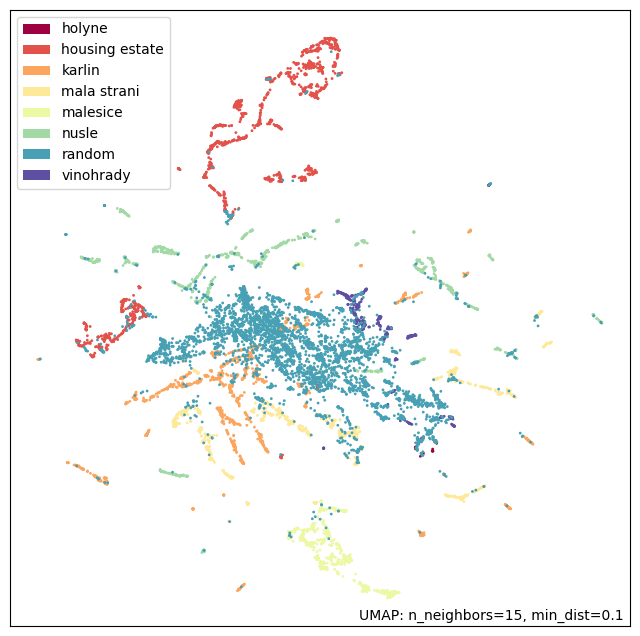

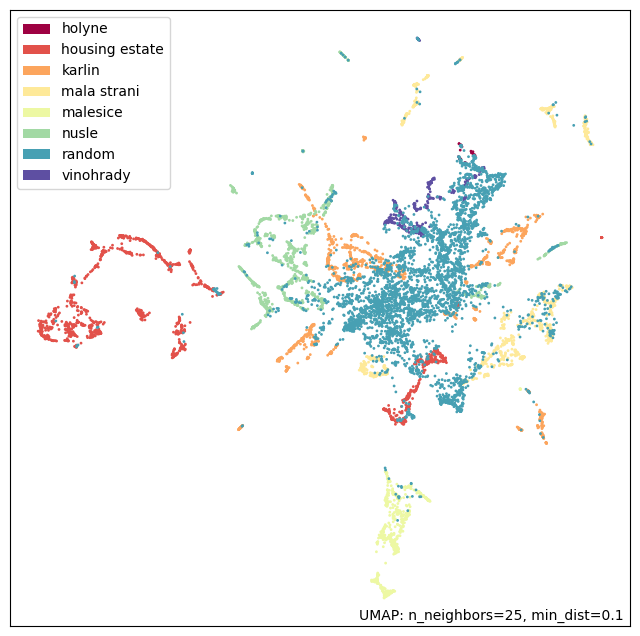

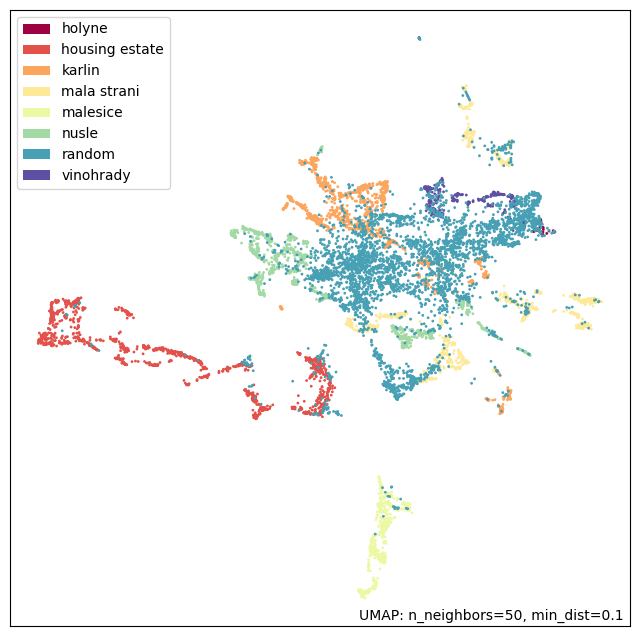

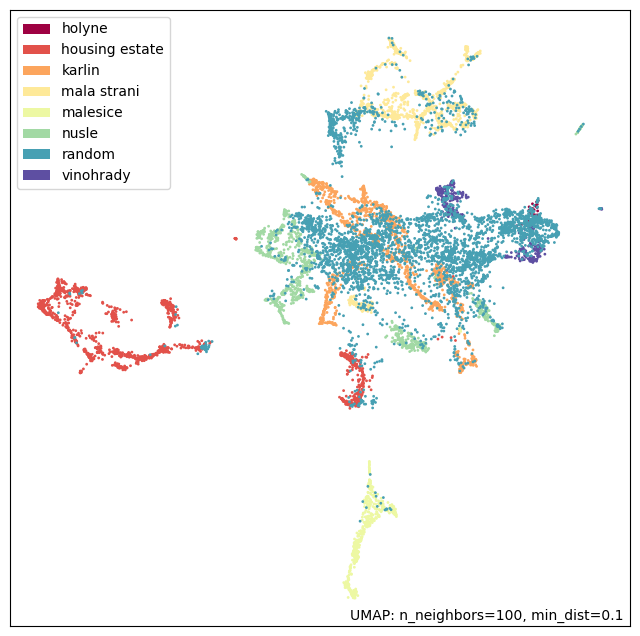

In [89]:
for n_neighbors in [15, 25, 50, 100]:
    show_nn(n_neighbors=n_neighbors, n_components=2, n_epochs=100, min_dist=0.1)

In [46]:
for n_neighbors in [15, 25, 50, 100]:
    for n_components in [5, 10, 15]:
        show_nn(
            n_neighbors=n_neighbors,
            n_components=n_components,
            n_epochs=500,
            min_dist=0.1,
        )

15 5 500 0.1 -- 1.4127280161498468
15 10 500 0.1 -- 1.335989354088617
15 15 500 0.1 -- 1.3167221667416629
25 5 500 0.1 -- 1.5001688901799717
25 10 500 0.1 -- 1.3345047808691204
25 15 500 0.1 -- 1.3158634415453951
50 5 500 0.1 -- 1.4639661554549583
50 10 500 0.1 -- 1.4012411750528682
50 15 500 0.1 -- 1.4340224511662558
100 5 500 0.1 -- 1.4749527721376092
100 10 500 0.1 -- 1.4680293072856825
100 15 500 0.1 -- 1.4717436010225011


In [256]:
for n_neighbors in [30, 100]:
    for n_components in [5, 10, 15]:
        for min_dist in [0.0, 0.05, 0.1]:
            show_nn(
                n_neighbors=n_neighbors,
                n_components=n_components,
                n_epochs=500,
                min_dist=min_dist,
            )

30 5 500 0.0 -- 1.2841309393811893
30 5 500 0.05 -- 1.3191500549507622
30 5 500 0.1 -- 1.5192874783862786
30 10 500 0.0 -- 1.3666322776266584
30 10 500 0.05 -- 1.3464628365470488
30 10 500 0.1 -- 1.4081037445687394
30 15 500 0.0 -- 1.2839097745932617
30 15 500 0.05 -- 1.3504032670022699
30 15 500 0.1 -- 1.3574552761136958
100 5 500 0.0 -- 1.4475180589343626
100 5 500 0.05 -- 1.4851821545442514
100 5 500 0.1 -- 1.4647877429123397
100 10 500 0.0 -- 1.447177501352741
100 10 500 0.05 -- 1.485871408118097
100 10 500 0.1 -- 1.4660062624913597
100 15 500 0.0 -- 1.4294311155558723
100 15 500 0.05 -- 1.4578181034282456
100 15 500 0.1 -- 1.4267898711043645


In [70]:
assert not X_train.duplicated().any()

In [90]:
reducer = umap.UMAP(n_neighbors=100, n_components=15, min_dist=0, verbose=True)
embedding = reducer.fit_transform(X_train)

UMAP(min_dist=0, n_components=15, n_neighbors=100, verbose=True)
Thu Jul 11 18:09:53 2024 Construct fuzzy simplicial set
Thu Jul 11 18:09:54 2024 Finding Nearest Neighbors
Thu Jul 11 18:09:54 2024 Building RP forest with 31 trees
Thu Jul 11 18:09:55 2024 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	Stopping threshold met -- exiting after 3 iterations
Thu Jul 11 18:10:50 2024 Finished Nearest Neighbor Search
Thu Jul 11 18:10:55 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Jul 11 18:14:54 2024 Finished embedding


In [72]:
viz_reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, verbose=True)
viz_embedding = viz_reducer.fit_transform(X_train)

UMAP(n_neighbors=30, verbose=True)
Mon Jul  1 13:06:08 2024 Construct fuzzy simplicial set
Mon Jul  1 13:06:08 2024 Finding Nearest Neighbors
Mon Jul  1 13:06:08 2024 Building RP forest with 30 trees
Mon Jul  1 13:06:10 2024 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	Stopping threshold met -- exiting after 2 iterations
Mon Jul  1 13:06:18 2024 Finished Nearest Neighbor Search
Mon Jul  1 13:06:19 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Jul  1 13:13:11 2024 Finished embedding


In [73]:
embedding_df = pd.DataFrame(embedding[tess_groups_ilocs, :3], index=tess_groups.index)
embedding_df["neighbourhood"] = tess_groups.values

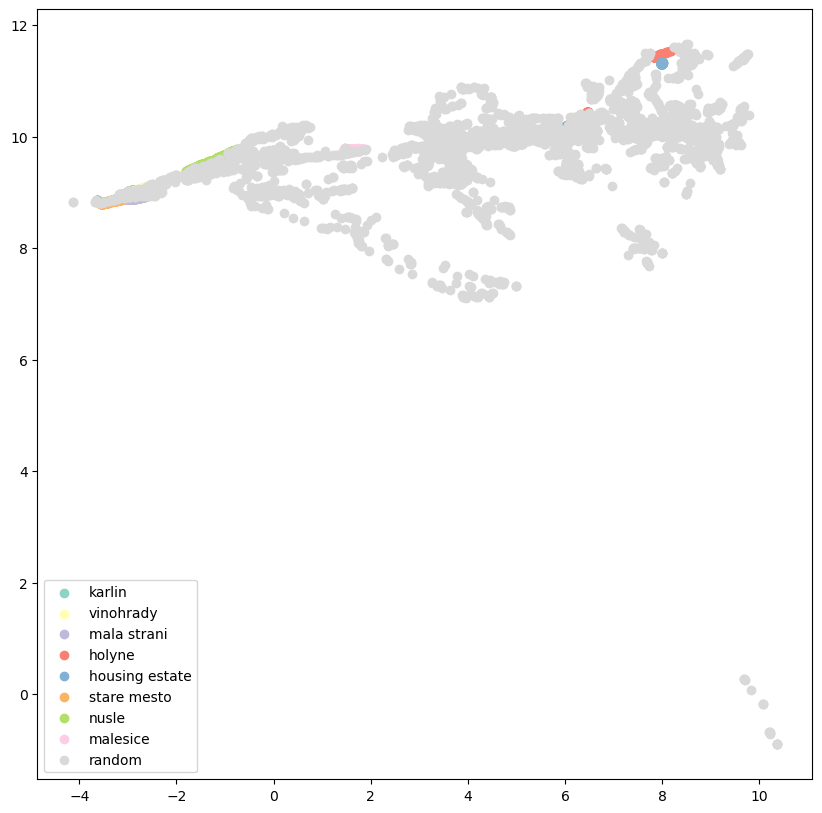

In [74]:
gb_cols = Set3_12.hex_colors

embedding_groups = embedding_df.groupby("neighbourhood")

gnames = embedding_df["neighbourhood"].unique()
genums = np.arange(len(gnames))

fig, ax = plt.subplots(figsize=(10, 10))

for genum, gname in zip(genums, gnames, strict=False):
    color = gb_cols[genum]
    label = gname
    es_ = embedding_groups.get_group(gname).values[:, :2]
    ax.scatter(es_[:, 0], es_[:, 1], color=color, label=label)
ax.legend()

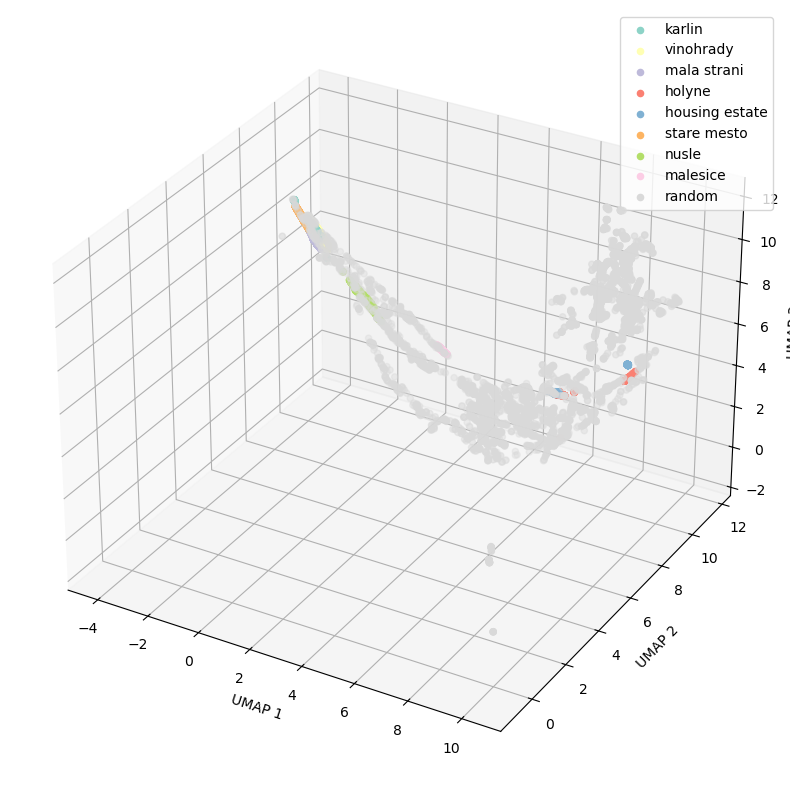

In [75]:
gb_cols = Set3_12.hex_colors

embedding_groups = embedding_df.groupby("neighbourhood")
gnames = embedding_df["neighbourhood"].unique()
genums = np.arange(len(gnames))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

for genum, gname in zip(genums, gnames, strict=False):
    color = gb_cols[genum]
    label = gname
    es_ = embedding_groups.get_group(gname).values[:, :3]
    ax.scatter(es_[:, 0], es_[:, 1], es_[:, 2], color=color, label=label)

ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
ax.legend()

In [76]:
# ax.view_init(45, 45)
# fig

In [77]:
# ax.view_init(45, 90)
# fig

In [78]:
# ax.view_init(45, 135)
# fig

In [79]:
davies_bouldin_score(embedding[tess_groups_ilocs, :], tess_groups.values)

1.3835807744970707

<Axes: >

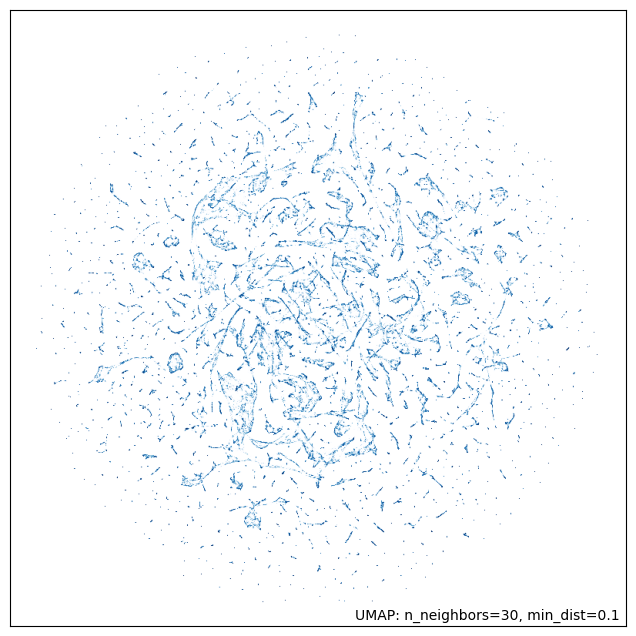

In [80]:
umap.plot.points(viz_reducer)

<Axes: title={'center': 'Colored by RGB coords of PCA embedding'}>

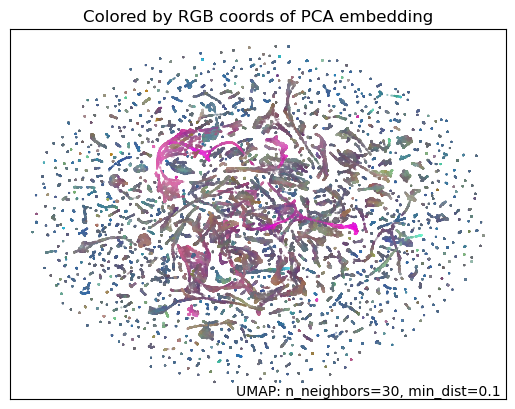

In [81]:
umap.plot.diagnostic(viz_reducer, diagnostic_type="pca")

<Axes: title={'center': 'Colored by RGB coords of Vector Quantization'}>

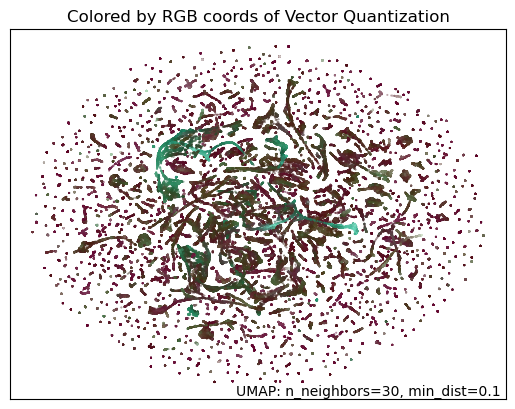

In [82]:
umap.plot.diagnostic(viz_reducer, diagnostic_type="vq")

Mon Jul  1 13:13:28 2024 Worst tree score: 0.91919930
Mon Jul  1 13:13:28 2024 Mean tree score: 0.92128518
Mon Jul  1 13:13:28 2024 Best tree score: 0.92306057
Mon Jul  1 13:13:30 2024 Forward diversification reduced edges from 7761690 to 1122124
Mon Jul  1 13:13:31 2024 Reverse diversification reduced edges from 1122124 to 1122124
Mon Jul  1 13:13:32 2024 Degree pruning reduced edges from 1054788 to 1054788
Mon Jul  1 13:13:32 2024 Resorting data and graph based on tree order
Mon Jul  1 13:13:32 2024 Building and compiling search function


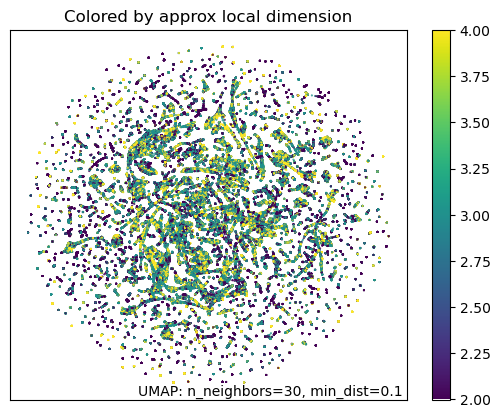

In [83]:
local_dims = umap.plot.diagnostic(viz_reducer, diagnostic_type="local_dim")

In [ ]:
### paint the UMAP embeddings by prague district

In [84]:
czech_admin = (
    gpd.read_file("data/MAP_CUR_MAP_MESTSKECASTI_P.zip")
    .sort_values("KOD_MC")
    .reset_index(drop=True)
)
admin_id, tess_id = tessellation.loc[X_train.index].sindex.query(
    czech_admin.geometry.to_crs(tessellation.crs), predicate="intersects"
)
import glasbey

gb_cols = glasbey.extend_palette(Set3_12.hex_colors, palette_size=max(admin_id) + 1)
czech_admin["color"] = gb_cols
labels = pd.Series("Bohemia", index=X_train.index)
labels.iloc[tess_id] = czech_admin.iloc[admin_id]["NAZEV_MC"].values
cmap = dict(zip(czech_admin["NAZEV_MC"].values, gb_cols, strict=False))
cmap["Bohemia"] = "#ffffff"

<Axes: >

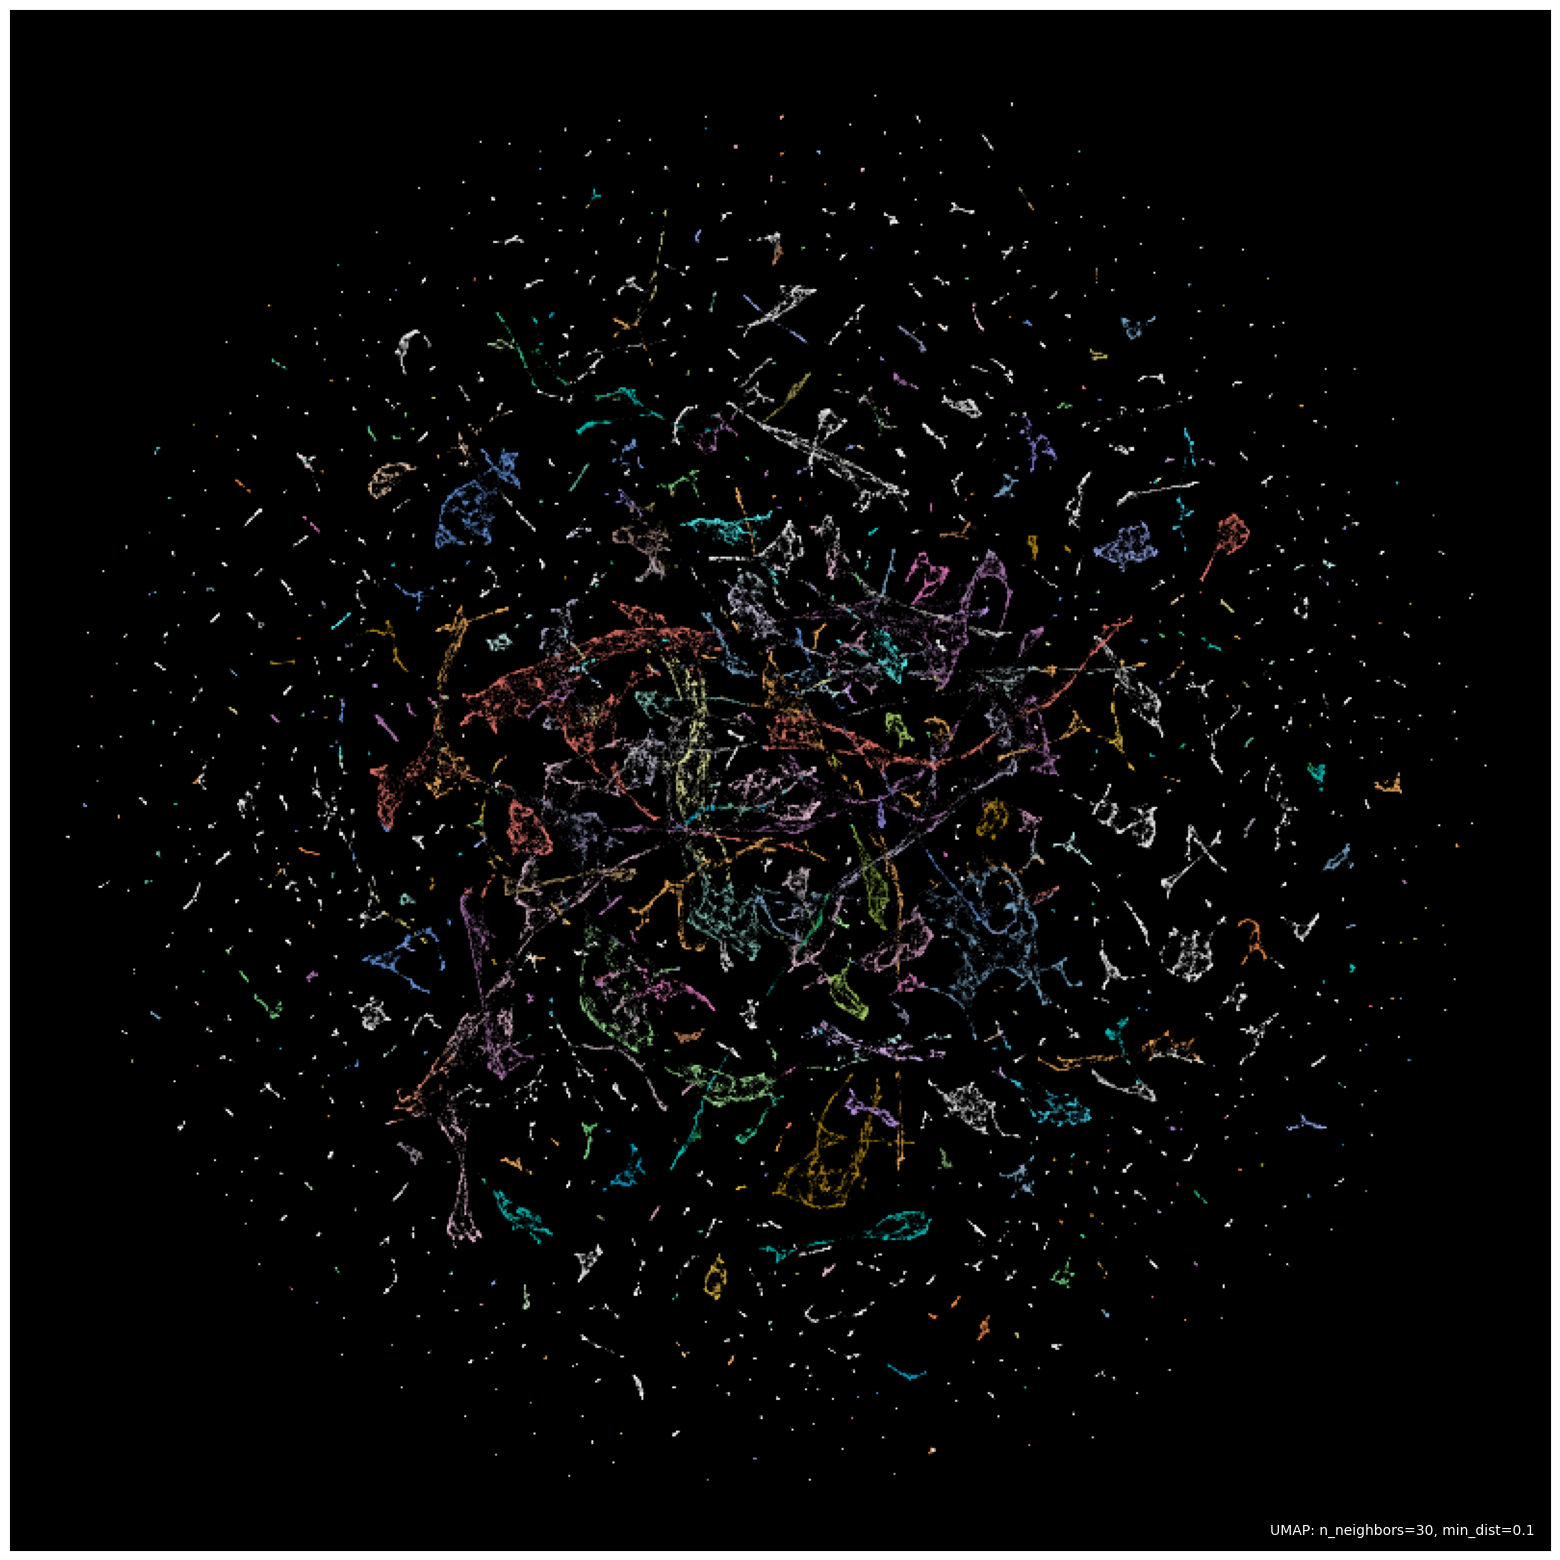

In [85]:
fig, ax = plt.subplots(figsize=(20, 20))
umap.plot.points(
    viz_reducer,
    labels=labels,
    background="black",
    color_key=cmap,
    show_legend=False,
    ax=ax,
)

<Axes: >

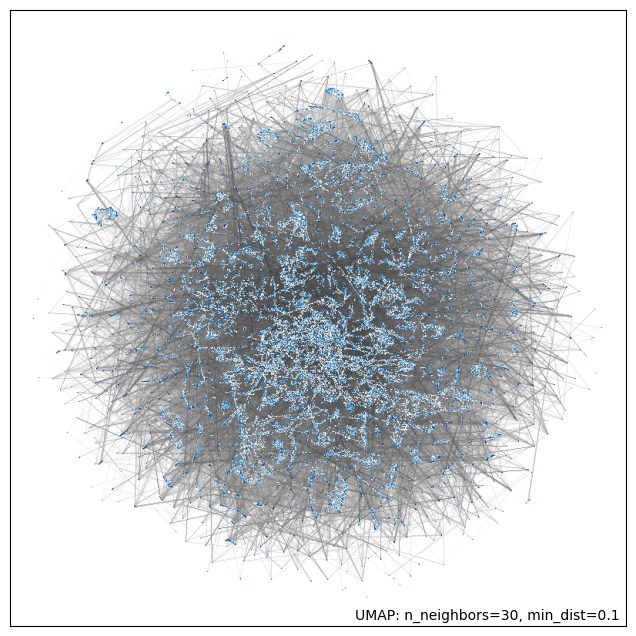

In [94]:
umap.plot.connectivity(viz_reducer, show_points=True)

In [ ]:
np.save(embedding)

In [ ]:
np.save("data/umap_prague_k7_n30_dim15.npy", embedding)

In [ ]:
embedding.shape

In [ ]:
np.load("data/umap_prague_k7_n30_dim15.npy").shape

In [63]:
# from sklearn.cluster import KMeans, MiniBatchKMeans
# from sklearn.metrics import adjusted_rand_score
# kmeans_label = KMeans(n_clusters=9, max_iter=1000, n_init=500).fit(embedding[tess_groups_ilocs, :50]).labels_
# adjusted_rand_score(tess_groups.values, kmeans_label)

In [64]:
# plotting = gpd.GeoDataFrame(tess_groups.to_frame(),
#                             geometry=tessellation.iloc[tess_groups_ilocs].geometry)
# plotting.columns = ['neighbourhood', 'geometry']
# plotting['neighbourhood'] = kmeans_label
# plotting.explore(column='neighbourhood', categorical=True)

In [65]:
# tessellation.loc[X_different[X_different.duplicated()].index.values].explore()

### PCA tests and comparison

In [91]:
from palettable.colorbrewer.qualitative import Set3_12
from sklearn.decomposition import PCA

In [92]:
%%time
pca_reducer = PCA(n_components=50)
pca_embedding = pca_reducer.fit_transform(X_train)

CPU times: user 2.31 s, sys: 164 ms, total: 2.47 s
Wall time: 166 ms


In [93]:
pca_reducer.explained_variance_ratio_.cumsum()

array([0.2875386 , 0.37565529, 0.43324214, 0.48374373, 0.52943724,
       0.56605423, 0.59766153, 0.62400044, 0.64910099, 0.6705688 ,
       0.69042555, 0.70790954, 0.72319984, 0.73584879, 0.74654957,
       0.75594766, 0.76483563, 0.77331324, 0.78114225, 0.78846483,
       0.795446  , 0.80233541, 0.80864304, 0.81479142, 0.82058687,
       0.82584289, 0.83065231, 0.83535573, 0.83990879, 0.84425385,
       0.84850651, 0.85258585, 0.85653603, 0.86039806, 0.86404996,
       0.86750678, 0.87088567, 0.87418583, 0.87742504, 0.88050051,
       0.88347926, 0.88635562, 0.88918041, 0.89189221, 0.89453131,
       0.89704442, 0.89950484, 0.90186827, 0.90420978, 0.9064494 ])

In [94]:
embedding_df = pd.DataFrame(pca_embedding[tess_groups_ilocs], index=tess_groups.index)
embedding_df["neighbourhood"] = tess_groups.values

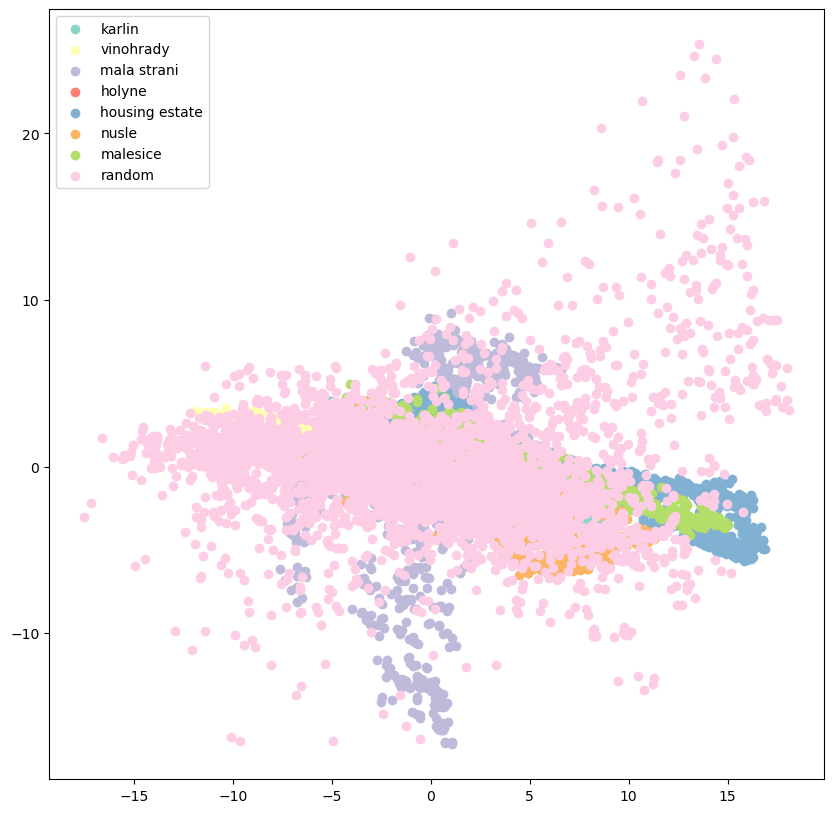

In [95]:
gb_cols = Set3_12.hex_colors

embedding_groups = embedding_df.groupby("neighbourhood")
gnames = embedding_df["neighbourhood"].unique()
genums = np.arange(len(gnames))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for genum, gname in zip(genums, gnames, strict=False):
    color = gb_cols[genum]
    label = gname
    es_ = embedding_groups.get_group(gname).values[:, :10]
    ax.scatter(es_[:, 0], es_[:, 1], color=color, label=label)

ax.legend()

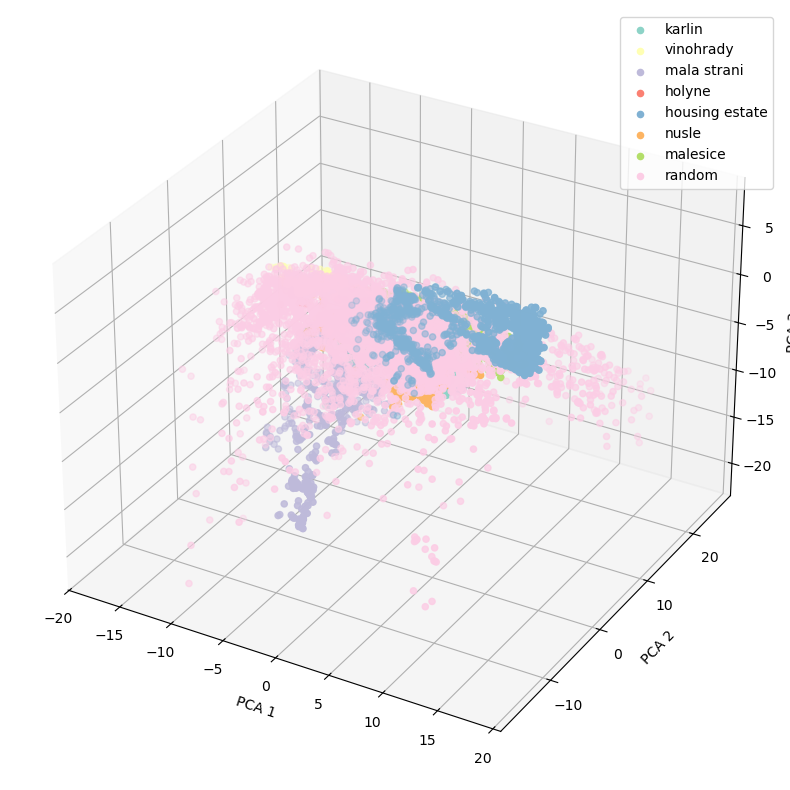

In [96]:
gb_cols = Set3_12.hex_colors

embedding_groups = embedding_df.groupby("neighbourhood")
gnames = embedding_df["neighbourhood"].unique()
genums = np.arange(len(gnames))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

for genum, gname in zip(genums, gnames, strict=False):
    color = gb_cols[genum]
    label = gname
    es_ = embedding_groups.get_group(gname).values[:, :3]
    ax.scatter(es_[:, 0], es_[:, 1], es_[:, 2], color=color, label=label)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.legend()

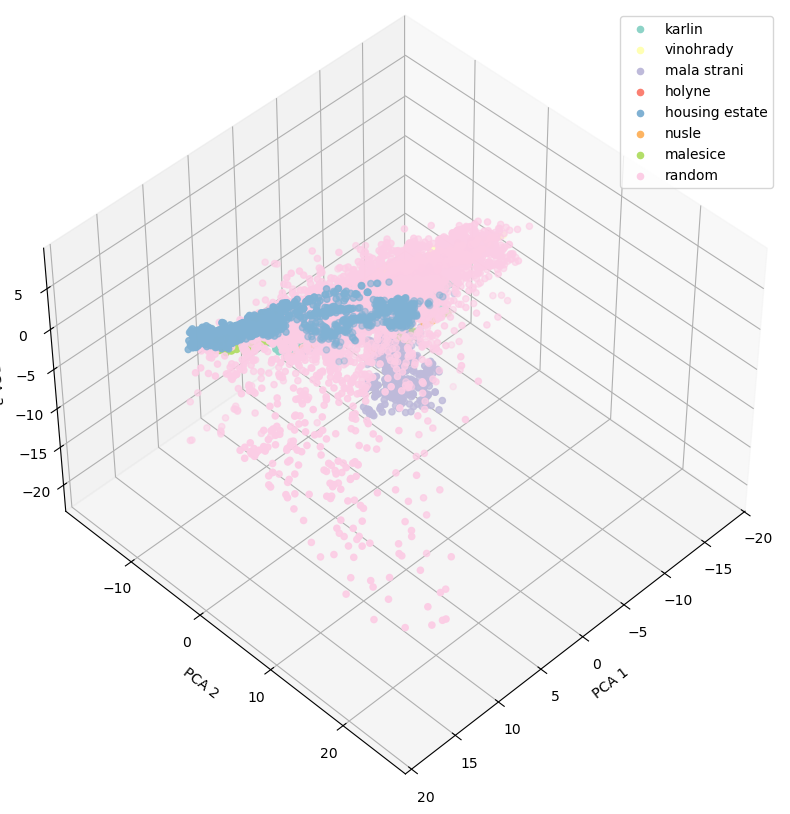

In [97]:
ax.view_init(45, 45)
fig

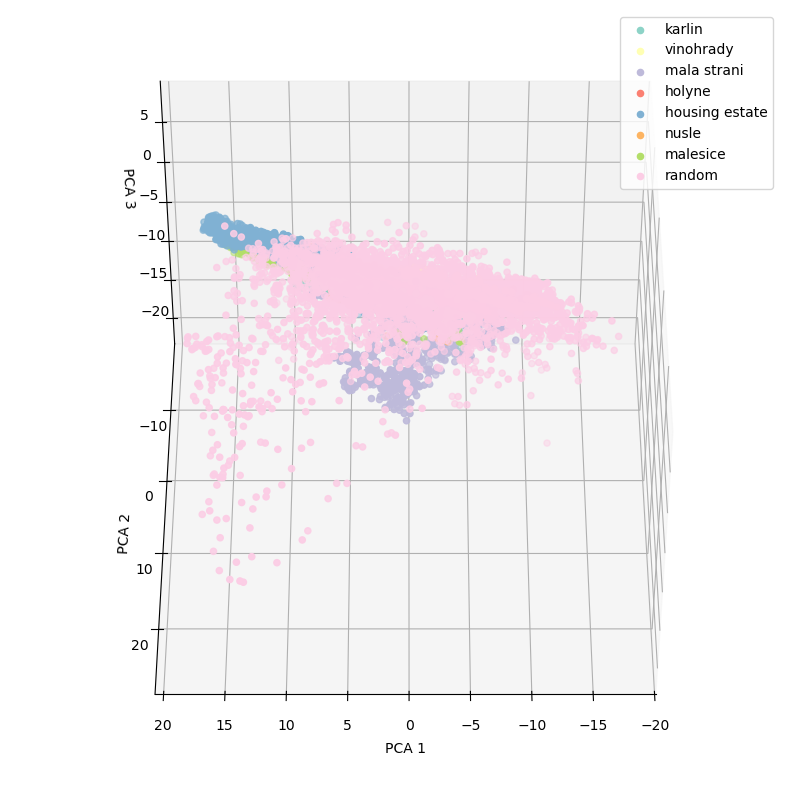

In [98]:
ax.view_init(45, 90)
fig

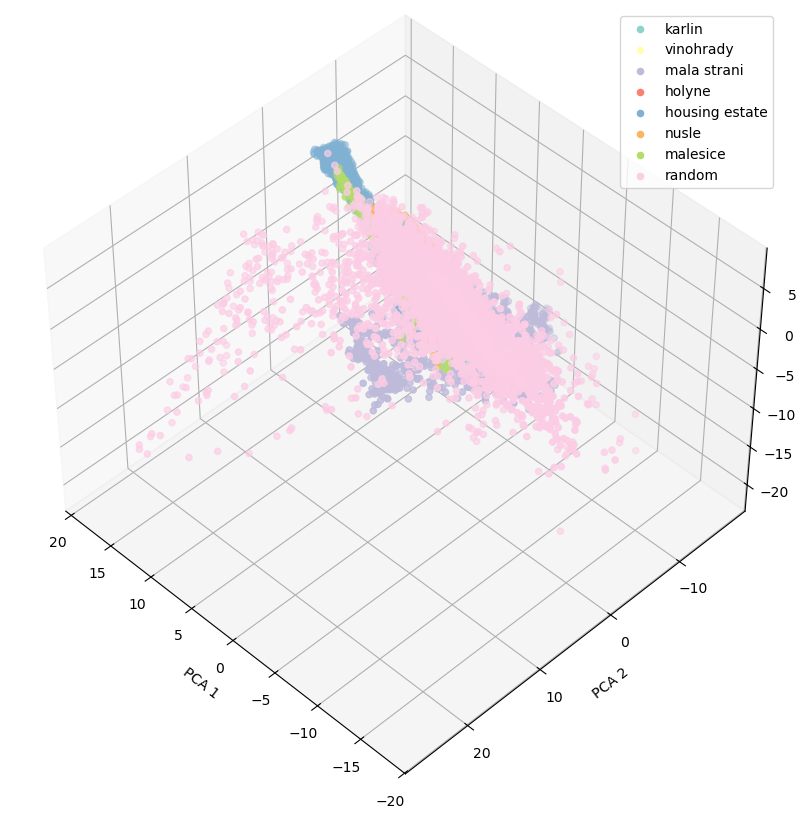

In [99]:
ax.view_init(45, 135)
fig

In [100]:
davies_bouldin_score(pca_embedding[tess_groups_ilocs, :20], tess_groups.values)

np.float64(2.84708321878714)

In [94]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

kmeans_label = (
    KMeans(n_clusters=9, max_iter=1000, n_init=500)
    .fit(pca_embedding[tess_groups_ilocs, :50])
    .labels_
)
adjusted_rand_score(tess_groups.values, kmeans_label)

0.3772136184146231

In [77]:
# from sklearn.cluster import KMeans, MiniBatchKMeans
# from sklearn.metrics import adjusted_rand_score
# kmeans_label = KMeans(n_clusters=9, max_iter=1000, n_init=500).fit(pca_embedding[:, :50]).labels_
# adjusted_rand_score(tess_groups.values, kmeans_label[tess_groups_ilocs])

In [95]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

kmeans_label = (
    KMeans(n_clusters=9, max_iter=1000, n_init=500)
    .fit(embedding[tess_groups_ilocs, :50])
    .labels_
)
adjusted_rand_score(tess_groups.values, kmeans_label)

0.3030778090511271

In [96]:
# plotting = gpd.GeoDataFrame(tess_groups.to_frame(),
#                             geometry=tessellation.iloc[tess_groups_ilocs].geometry)
# plotting.columns = ['neighbourhood', 'geometry']
# plotting['neighbourhood'] = kmeans_label
# plotting.explore(column='neighbourhood', categorical=True)

In [112]:
# np.save('../data/umap.npy', embedding)
# embedding = np.load('../data/umap.npy')

### HDBSCAN

In [7]:
from fast_hdbscan.boruvka import parallel_boruvka
from fast_hdbscan.cluster_trees import (
    cluster_tree_from_condensed_tree,
    condense_tree,
    extract_eom_clusters,
    get_cluster_label_vector,
    mst_to_linkage_tree,
)
from fast_hdbscan.numba_kdtree import kdtree_to_numba
from sklearn.neighbors import KDTree

In [8]:
min_cluster_size = 100

In [9]:
%%time
sklearn_tree = KDTree(embedding)

CPU times: user 248 ms, sys: 7.73 ms, total: 256 ms
Wall time: 253 ms


In [10]:
%%time
numba_tree = kdtree_to_numba(sklearn_tree)

CPU times: user 9 μs, sys: 0 ns, total: 9 μs
Wall time: 10.5 μs


In [11]:
%%time
edges = parallel_boruvka(numba_tree, min_samples=min_cluster_size)

CPU times: user 13.6 s, sys: 73.5 ms, total: 13.7 s
Wall time: 1.09 s


In [12]:
sorted_mst = edges[np.argsort(edges.T[2])]

In [13]:
%%time
linkage_tree = mst_to_linkage_tree(sorted_mst)

CPU times: user 9.49 ms, sys: 0 ns, total: 9.49 ms
Wall time: 9.47 ms


In [14]:
condensed_tree = condense_tree(linkage_tree, min_cluster_size=500)
cluster_tree = cluster_tree_from_condensed_tree(condensed_tree)
selected_clusters = extract_eom_clusters(
    condensed_tree, cluster_tree, allow_single_cluster=False
)
clusters = get_cluster_label_vector(condensed_tree, selected_clusters, 0)

In [15]:
adjusted_rand_score(tess_groups.values, clusters[tess_groups_ilocs])

NameError: name 'adjusted_rand_score' is not defined

In [16]:
np.unique(clusters, return_counts=True)

(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165]),
 array([34449,   803,   769,  1228,  1200,  1534,   710,  2

In [97]:
from lonboard import PolygonLayer, Map
from lonboard.basemap import CartoBasemap
from lonboard.colormap import apply_categorical_cmap
from palettable.colorbrewer.qualitative import Set3_12

In [91]:
plotting = tessellation.loc[X_train.index].copy()

plotting["label"] = clusters + 1
plotting = plotting[plotting["label"] > 0]

In [92]:
import glasbey


def hex_to_rgb(hexa):
    return tuple(int(hexa[i : i + 2], 16) for i in (0, 2, 4))


gb_cols = glasbey.extend_palette(
    Set3_12.hex_colors, palette_size=plotting["label"].unique().shape[0] + 1
)
gb_cols = [hex_to_rgb(c[1:]) for c in gb_cols]

colors = apply_categorical_cmap(
    plotting["label"], cmap=dict(zip(np.unique(plotting["label"]), gb_cols, strict=False))
)

In [93]:
layer = PolygonLayer.from_geopandas(
    gdf=plotting[["geometry", "label"]], get_fill_color=colors, opacity=0.15
)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


In [99]:
# m = Map(layer, basemap_style=CartoBasemap.Positron)
# m